/Users/songyuru/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Step 1,before optimize, Minibatch Loss= 3.5170
Step 1, Minibatch Loss= 0.6204


/Users/songyuru/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in arcsin
/Users/songyuru/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:137: RuntimeWarning: invalid value encountered in arcsin
/Users/songyuru/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:181: RuntimeWarning: invalid value encountered in arcsin
/Users/songyuru/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:180: RuntimeWarning: invalid value encountered in arcsin
/Users/songyuru/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:209: RuntimeWarning: invalid value encountered in arcsin
/Users/songyuru/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:215: RuntimeWarning: invalid value encountered in arcsin
/Users/songyuru/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:210: RuntimeWarning: invalid value encountered in arcsin
/Users/songyuru/anaconda2/lib/python2.7/site-packages/ipykernel_launc

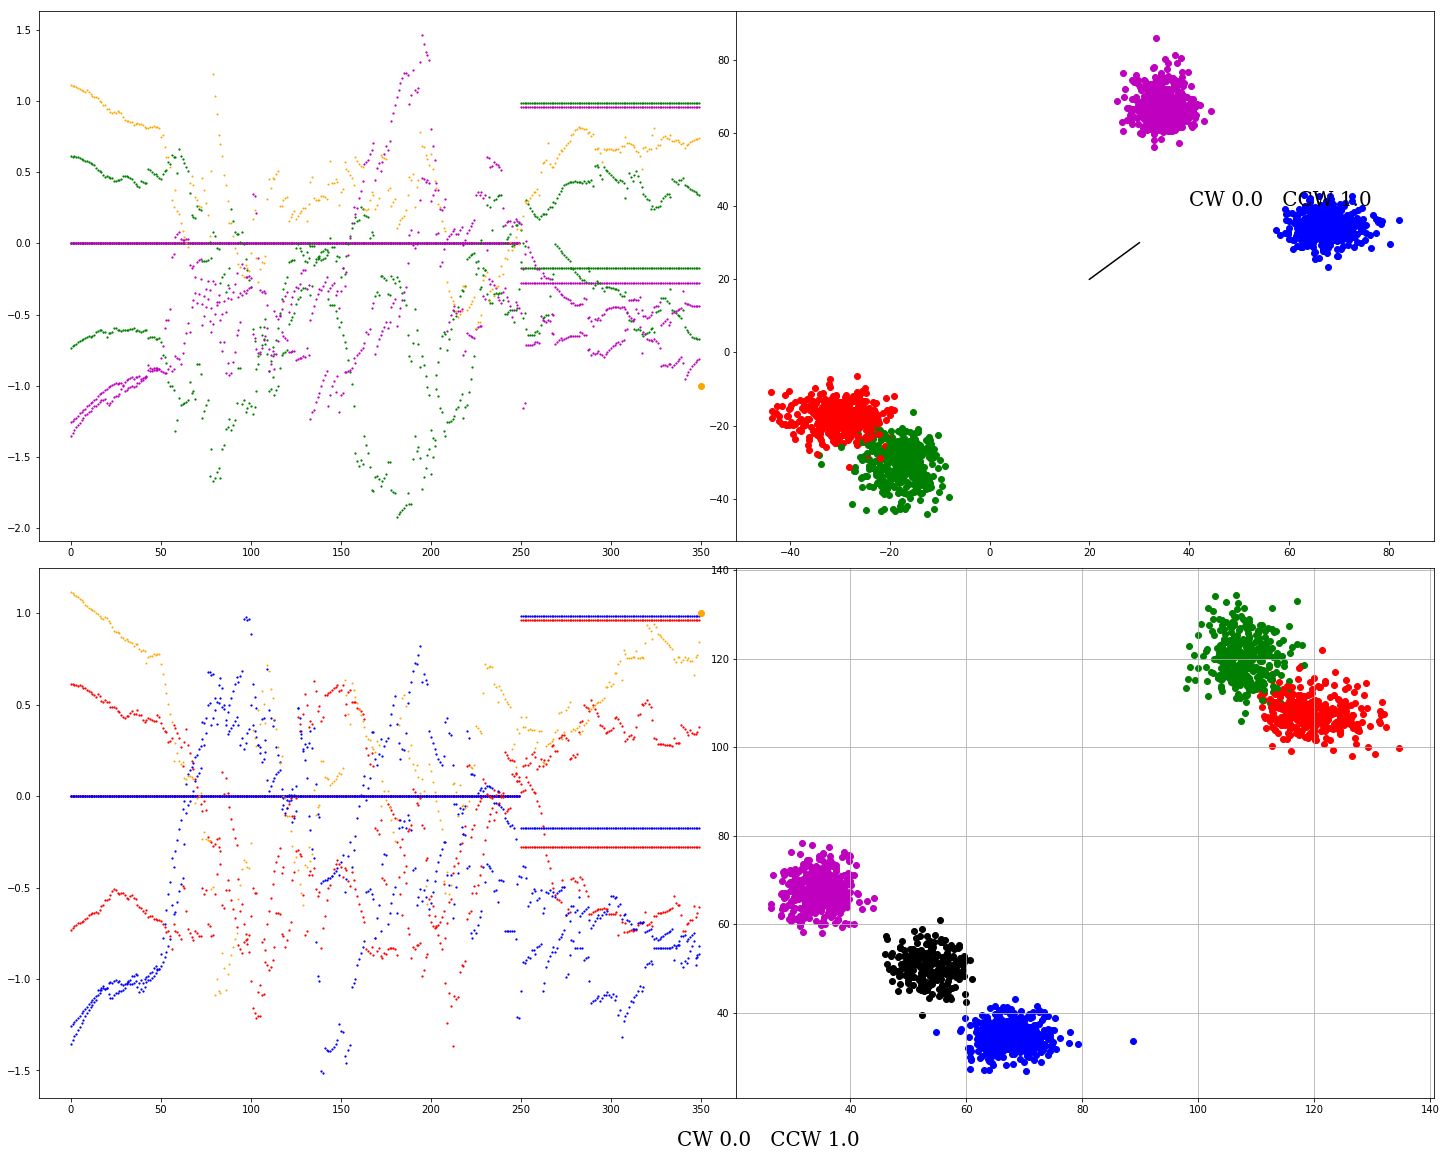

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt
import sys
import pickle
sys.path.append("./")
import FR_RNN3 as FR
import matplotlib.cm as cm
%matplotlib inline
learning_rate = 0.001
training_steps = 5000
batch_size = 100
display_step = 50
epoch = 10
beta = .0001
# Network Parameters
num_input =32 
timesteps = 350 # timesteps
num_hidden = 100 # hidden layer num of features
num_layers = 1
num_classes = 6
# tf Graph input
X = tf.placeholder("float", [None, timesteps, num_input],name = "X")
Y = tf.placeholder("float", [None, timesteps, num_classes], name = "Y")

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([num_hidden, num_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([num_classes]))
}

#define RNNcell using firing rate model
def RNN(X, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, timesteps, n_input)
    # Required shape: 'timesteps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, n_input)
#     x = tf.unstack(X, timesteps, 1)

    # Define a FR rnn cell with tensorflow
#     FR_cell = FR.FiringRateRNNCell(num_hidden)
#     dropout_FR_cell = FR.DropoutWrapper(FR_cell,input_keep_prob=0.6,output_keep_prob=0.6)

    cells = []
    for _ in range(num_layers):
      cell = FR.FiringRateRNNCell(num_hidden)  # Or LSTMCell(num_units)
#       cell = rnn.DropoutWrapper(cell,output_keep_prob=0.9)
      cells.append(cell)
    cell = rnn.MultiRNNCell(cells)
    
    
    
    # Get FR cell output
#     state = FR_cell.zero_state(batch_size,dtype=tf.float32)
    outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    # W = tf.tile(weights['out'],[timesteps,1])
    return outputs
# outputs_hidden = RNN(X, weights, biases)
# logits = tf.matmul(outputs_hidden[-1], weights['out']) + biases['out']
# prediction = tf.nn.relu(logits)
# hidden_belogits= RNN(X, weights, biases)
# for i in range(batch_size):
#     logits[i] = tf.matmul(tf.tanh(logits[i]),weights['out'])+biases['out']
#     hidden_before_act[i] = tf.matmul(hidden_after_act[i],weights['out'])+biases['out']
# hidden_before_act = RNN(X, weights, biases)
hidden_before_act = RNN(X, weights, biases)
hidden_after_act = tf.tanh(hidden_before_act,name = 'hidden_after_act')
hidden_before_act = tf.reshape(hidden_before_act,[-1,num_hidden])
logits = tf.matmul(tf.tanh(hidden_before_act),weights['out']) + biases['out']
logits = tf.reshape(logits,[-1, timesteps, num_classes],name = 'logits')


# Define loss and optimizer
loss_op = tf.reduce_mean(tf.square(logits - Y),name = 'loss_op')+tf.reduce_mean(tf.nn.l2_loss(weights['out']))*beta
# loss_op2 = tf.reduce_mean(tf.square(tf.nn.softmax(logits[:,:,-2:]) - tf.nn.softmax(Y[:,:,-2:])),name = 'loss_op2')
# loss_op = loss_op1 + loss_op2
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,name = 'Adam')
gvs = optimizer.compute_gradients(loss_op)
capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
train_op = optimizer.apply_gradients(capped_gvs)
init = tf.global_variables_initializer()
loss_history = []
test_history = []
CCW_acc = []
CW_acc = []

saver = tf.train.Saver()

# Start training
font2 = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 20,
        }
c = 0
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for step in range(1, training_steps+1):
        batch_x, batch_y = FR.VPDATAtrainingN1(BatchSize=batch_size,ratio = .25*(1-np.float64(step)/training_steps)+.03)
        # Run optimization op (backprop)
        if step % display_step == 0 or step == 1:
            loss = sess.run(loss_op , feed_dict={X: batch_x, Y: batch_y})
            print("Step " + str(step) + ",before optimize, Minibatch Loss= " + \
                  "{:.4f}".format(loss) )
            test_history.append(loss)
        for i in range(epoch): 
            sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss,logits_ ,hidden= sess.run([loss_op,logits,hidden_after_act], feed_dict={X: batch_x, Y: batch_y})
            loss_history.append(loss)
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) ) 
            saver.save(sess, './hiddenNoise001/TwoAngleORL2beta00001-new/hiddenNoise001',global_step=step)   
            fig1, axs1 = plt.subplots(2,2,figsize=(25, 20))
            fig1.subplots_adjust(hspace = .05, wspace=.001)
            axs1 = axs1.ravel()
            
            batchX,batchY = FR.VPDATAtestN1(a1 = 20,a2 = 30)
            feed_dict ={X:batchX,Y:batchY}
            logitsOR_1 = sess.run(logits,feed_dict)
            batchX,batchY = FR.VPDATAtestN2(a1 = 30,a2 = 20)
            feed_dict ={X:batchX,Y:batchY}
            logitsOR_2  = sess.run(logits,feed_dict)
            a = 0
            b = 0
            i = 1

            for j in range(500):
                axs1[i].scatter(np.arcsin(logitsOR_2[j,349:350,2])*90./np.pi,(np.arcsin(logitsOR_2[j,349:350,0])*90./np.pi),c = 'r')
                axs1[i].scatter(np.arcsin(logitsOR_1[j,349:350,0])*90./np.pi,(np.arcsin(logitsOR_1[j,349:350,2])*90./np.pi),c = 'g')
                axs1[i].scatter(np.arccos(logitsOR_2[j,349:350,3])*90./np.pi,(np.arccos(logitsOR_2[j,349:350,1])*90./np.pi),c ='b')
                axs1[i].scatter(np.arccos(logitsOR_1[j,349:350,1])*90./np.pi,(np.arccos(logitsOR_1[j,349:350,3])*90./np.pi),c ='m')
                if logitsOR_1[j,349:350,4]<logitsOR_1[j,349:350,5]:
                    a = a+1
                if logitsOR_2[j,349:350,5]<logitsOR_2[j,349:350,4]:
                    b = b+1
            axs1[i].text(40,40,"CW "+str(a/500.)+"   CCW "+str(b/500.),fontdict = font2)
            axs1[i].plot([20,30],[20,30],c = 'k')
            batchX,batchY = FR.VPDATAtestN1(a1 = 42.5,a2 = 47.5)
            feed_dict ={X:batchX,Y:batchY}
            logitsOR_1 = sess.run(logits,feed_dict)
            batchX,batchY = FR.VPDATAtestN2(a1 = 47.5,a2 = 42.5)
            feed_dict ={X:batchX,Y:batchY}
            logitsOR_2  = sess.run(logits,feed_dict)
            plt.grid('True')
#             i = 2
#             axs1[i].plot([42.5,47.5],[42.5,47.5],c ='k')
#             a = 0
#             b = 0
#             for j in range(500):
#                 axs1[i].scatter(np.arcsin(logitsOR_2[j,349:350,2])*90./np.pi,90.-(np.arcsin(logitsOR_2[j,349:350,0])*90./np.pi),c = 'r')
#                 axs1[i].scatter(np.arcsin(logitsOR_1[j,349:350,0])*90./np.pi,90.-(np.arcsin(logitsOR_1[j,349:350,2])*90./np.pi),c = 'g')
#                 axs1[i].scatter(np.arccos(logitsOR_2[j,349:350,3])*90./np.pi,(np.arccos(logitsOR_2[j,349:350,1])*90./np.pi),c ='b')
#                 axs1[i].scatter(np.arccos(logitsOR_1[j,349:350,1])*90./np.pi,(np.arccos(logitsOR_1[j,349:350,3])*90./np.pi),c ='m')
#                 if logitsOR_1[j,349:350,4]<logitsOR_1[j,349:350,5]:
#                     a = a+1
#                 if logitsOR_2[j,349:350,5]<logitsOR_2[j,349:350,4]:
#                     b = b+1
#             axs1[i].text(20,20,"CW "+str(a/500.)+"   CCW "+str(b/500.),fontdict = font2)
            batchX,batchY1 = FR.VPDATAtestN1(a1 = 50,a2 = 53)
            feed_dict ={X:batchX,Y:batchY1}
            logitsOR_1 = sess.run(logits,feed_dict)
            batchX,batchY2 = FR.VPDATAtestN2(a1 = 53,a2 = 50)
            feed_dict ={X:batchX,Y:batchY2}
            logitsOR_2  = sess.run(logits,feed_dict)
            plt.grid('True')
            i = 3
            a = 0
            b = 0
            axs1[i].plot([50,53],[50,53],c = 'k')
            for j in range(400):
                axs1[i].scatter(90-np.arcsin(logitsOR_2[j,349:350,2])*90./np.pi,90-(np.arcsin(logitsOR_2[j,349:350,0])*90./np.pi),c = 'r')
                axs1[i].scatter(90-np.arcsin(logitsOR_1[j,349:350,0])*90./np.pi,90-(np.arcsin(logitsOR_1[j,349:350,2])*90./np.pi),c = 'g')
                axs1[i].scatter(np.arccos(logitsOR_2[j,349:350,3])*90./np.pi,(np.arccos(logitsOR_2[j,349:350,1])*90./np.pi),c ='b')
                axs1[i].scatter(np.arccos(logitsOR_1[j,349:350,1])*90./np.pi,(np.arccos(logitsOR_1[j,349:350,3])*90./np.pi),c ='m')
                
            for j in range(1000):
                if logitsOR_1[j,349:350,4]<logitsOR_1[j,349:350,5]:
                    a = a+1
                if logitsOR_2[j,349:350,5]<logitsOR_2[j,349:350,4]:
                    b = b+1
            CCW_acc.append(a/1000.)
            CW_acc.append(b/1000.)
# #             print(CCW_acc)
#             print(CW_acc)
            if a>900 & b>900:
                c = c+1
            if c>10:
                break
            axs1[i].text(10,10,"CW "+str(a/1000.)+"   CCW "+str(b/1000.),fontdict = font2)
            file = open("hiddenNoise001TwoAngle.obj",'rb')
            [logits_11,logits_12] = pickle.load(file)
            file.close()
            for k in range(100):
#     plt.scatter((np.arcsin(np.mean(logits_1[i,199,0]))*45/np.pi)+np.arccos(np.mean(logits_1[i,199,1]))*45/np.pi,(np.arcsin(np.mean(logits_2[i,199,0]))*45/np.pi)+np.arccos(np.mean(logits_2[i,199,1]))*45/np.pi,c = 'k')
#     plt.scatter((np.arcsin(np.mean(logits_1[i,299,0]))*90/np.pi)+np.arccos(np.mean(logits_1[i,299,1]))*90/np.pi,(np.arcsin(np.mean(logits_2[i,12:20,0]))*90/np.pi)+(np.arccos(np.mean(logits_2[i,12:20,1]))*90/np.pi),s = 5.,c = 'k')
       
                a1 = np.arccos(logits_12[k,299,3])*90./np.pi
                a2 = np.arccos(logits_12[k,299,1])*90./np.pi
                axs1[i].scatter(a1,a2,c ='k')
                a1 =90- np.arcsin(logits_12[k,299,2])*90./np.pi
                a2 =90- np.arcsin(logits_12[k,299,0])*90./np.pi
                axs1[i].scatter(a1,a2,c ='k')
                a1 = np.arccos(logits_11[k,299,3])*90./np.pi
                a2 = np.arccos(logits_11[k,299,1])*90./np.pi
                axs1[i].scatter(a1,a2,c ='k')
                a1 =90- np.arcsin(logits_11[k,299,2])*90./np.pi
                a2 =90- np.arcsin(logits_11[k,299,0])*90./np.pi
                axs1[i].scatter(a1,a2,c ='k')
#                 axs1[i].plot(j*180./350.,[logits_[i,j,16]])
#                 axs1[i].plot(j*180./350.,[batch_y[i,j,16]])
            
# #             fig.subplots_adjust(hspace = .05, wspace=.001)
# #             axs = axs.ravel()
# #             for i in range(25):
# #                 for j in range(100):
# #                     axs[i].plot(np.arange(timesteps),hidden[i,:,j],linewidth = .5)
            plt.grid('True')  
            i=0
            axs1[i].scatter(np.arange(timesteps),batchY1[i,:,0],c = 'g',s = 1.5)
            axs1[i].scatter(np.arange(timesteps),batchY1[i,:,1],c = 'g',s = 1.5)
            axs1[i].scatter(np.arange(timesteps),batchY1[i,:,2],c = 'm',s = 1.5)             
            axs1[i].scatter(np.arange(timesteps),batchY1[i,:,3],c = 'm',s = 1.5)
            axs1[i].scatter([timesteps],batchY1[i,timesteps-1,4]-batchY1[i,timesteps-1,5],c = 'orange')
#                 axs1[i].scatter([timesteps],batch_y[i,timesteps-1,5],c = 'm')
            axs1[i].scatter(np.arange(timesteps),logitsOR_1[i,:,0],c = 'g',s = 1.5)
            axs1[i].scatter(np.arange(timesteps),logitsOR_1[i,:,1],c = 'g',s = 1.5)
            axs1[i].scatter(np.arange(timesteps),logitsOR_1[i,:,2],c = 'm',s = 1.5)
            axs1[i].scatter(np.arange(timesteps),logitsOR_1[i,:,3],c = 'm',s = 1.5)
            axs1[i].scatter(np.arange(timesteps),np.multiply(logitsOR_1[i,:,4]-logitsOR_1[i,:,5],1.),c = 'orange',s = 1.)
            i =2
            axs1[i].scatter(np.arange(timesteps),batchY2[i,:,0],c = 'r',s = 1.5)
            axs1[i].scatter(np.arange(timesteps),batchY2[i,:,1],c = 'r',s = 1.5)
            axs1[i].scatter(np.arange(timesteps),batchY2[i,:,2],c = 'b',s = 1.5)             
            axs1[i].scatter(np.arange(timesteps),batchY2[i,:,3],c = 'b',s = 1.5)
            axs1[i].scatter([timesteps],batchY2[i,timesteps-1,4]-batchY2[i,timesteps-1,5],c = 'orange')
#                 axs1[i].scatter([timesteps],batch_y[i,timesteps-1,5],c = 'm')
            axs1[i].scatter(np.arange(timesteps),logitsOR_2[i,:,0],c = 'r',s = 1.5)
            axs1[i].scatter(np.arange(timesteps),logitsOR_2[i,:,1],c = 'r',s = 1.5)
            axs1[i].scatter(np.arange(timesteps),logitsOR_2[i,:,2],c = 'b',s = 1.5)
            axs1[i].scatter(np.arange(timesteps),logitsOR_2[i,:,3],c = 'b',s = 1.5)
            axs1[i].scatter(np.arange(timesteps),np.multiply(logitsOR_2[i,:,4]-logitsOR_2[i,:,5],1.),c = 'orange',s = 1.)
           
            plt.show()

In [ ]:
plt.figure(figsize=(15,15))
plt.plot(np.multiply(100.0,range(np.size(loss_history))),loss_history)
plt.plot(np.multiply(100.0,range(np.size(loss_history))),CCW_acc)
plt.plot(np.multiply(100.0,range(np.size(loss_history))),CW_acc)
# plt.title("Loss history, gaussian noise in hidden unit , std: 0.01, TwoAngleOR")
plt.xlabel("Steps")
plt.ylabel("Loss history")
plt.ylim([0,1.0])
plt.savefig("hiddenNoise01.jpeg")